# Imports

In [1]:
from fastai.vision.all import *
from fastai.callback.fp16 import *

import pandas as pd
import numpy as np

from IPython.display import display
from PIL import Image

import wandb
from fastai.callback.wandb import *

import albumentations

wandb.login(key="11b470b697ff94b3896d2243b147d42177a5cb7a")
wandb.init(project="cassava", entity="teo03", config="../input/cassavamodel1/config.yaml")

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: teo03 (use `wandb login --relogin` to force relogin)


Make the results reproducible

In [2]:
set_seed(420, reproducible=True)

# Setup

In [3]:
path_str = '../input/cassava-leaf-disease-classification'
PATH = Path(path_str)

images_path = Path(path_str + '/train_images')
csv_path = Path(path_str + '/train.csv')

# Some Data Analysis

Get the default image height and width

In [4]:
test_image = Image.open((images_path).ls()[6])

test_image.shape

(600, 800)

View the csv data

In [5]:
train_df = pd.read_csv(csv_path)
train_df['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

# Create a smaller dataset

In [ ]:
#msk = np.random.rand(len(train_df)) < 0.2

In [ ]:
#small_df = train_df[msk]
#small_df['label'].value_counts(), len(small_df)

# Data Preprocessing

Create a transform handler for multiple albumentation transforms

In [6]:
class AlbumentationsTransform(RandTransform):
    split_idx,order = None, 2
    
    def __init__(self, train_aug, valid_aug): 
        store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [7]:
def get_train_aug(size): 
    return albumentations.Compose([
            albumentations.RandomResizedCrop(size, size),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.6),
            albumentations.VerticalFlip(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

In [8]:
def get_valid_aug(size): 
    return albumentations.Compose([
        albumentations.CenterCrop(size, size, p=1.),
        albumentations.Resize(size, size),
], p=1.)

In [9]:
def get_x(row): return images_path/row['image_id']
def get_y(row): return row['label']

In [10]:
blocks = (ImageBlock, CategoryBlock)
splitter = RandomSplitter(valid_pct=0.2)

item_tfms = [Resize(wandb.config.image_size),
             AlbumentationsTransform(
                 get_train_aug(size=int(wandb.config.image_size/2)),
                 get_valid_aug(size=int(wandb.config.image_size/2))
             )]

batch_tfms = [Normalize.from_stats(*imagenet_stats)]

block = DataBlock(blocks=blocks, get_x=get_x, get_y=get_y, splitter=splitter, item_tfms=item_tfms, batch_tfms=batch_tfms)

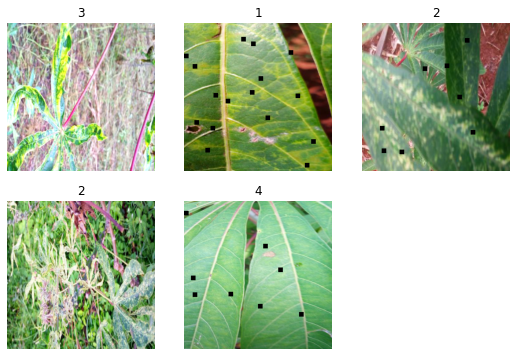

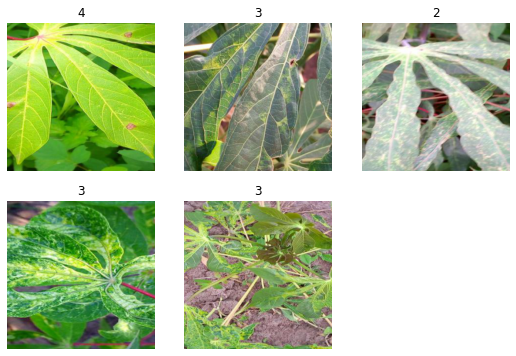

In [11]:
dls = block.dataloaders(train_df, bs=wandb.config.batch_size)

dls.train.show_batch(max_n=5)
dls.valid.show_batch(max_n=5)

In [67]:
fastai??

Object `fastai` not found.


# Model

In [14]:
learn = cnn_learner(dls,
                    eval(wandb.config.model),
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=accuracy,
                    opt_func=eval(wandb.config.optimizer),
                    cbs=[
                        WandbCallback(log_preds=True, log_model=True),
                        SaveModelCallback()
                    ]
                   )

# Training

0.02089296132326126

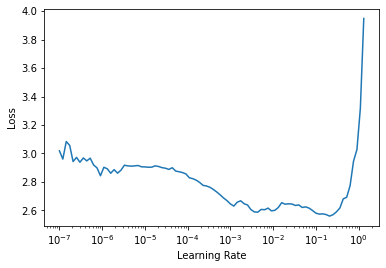

In [15]:
lr_min, lr_steep = learn.lr_find()
lr_min

In [19]:
round(lr_min, 3)

0.021

In [ ]:
learn.fine_tune(wandb.config.epochs, base_lr=round(lr_min, 3), freeze_epochs=wandb.config.freeze_epochs)

In [ ]:
learn.export(Path("./fastai-model.pkl"))